## overview

In [1]:
# default package
import dataclasses as dc
import logging
import os
import pathlib
import random
import sys
import tempfile
from urllib.request import urlretrieve

import IPython

In [2]:
# third party package
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from tqdm import tqdm
from matplotlib.animation import FuncAnimation

In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(), "../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [6]:
# graph setting
sns.set()
font_path = "/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf"
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams["font.family"] = font_prop.get_name()

## func

In [7]:
def func(x: np.ndarray) -> np.ndarray:
    return (x - 1) * x * (x + 1) * (x - 0.25) - 0.1 * x ** 2

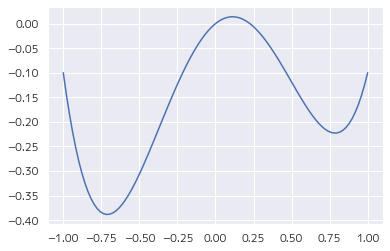

In [8]:
x = np.linspace(-1, 1, 100)
plt.plot(x, func(x))

## gp

In [9]:
x_train = np.array([-0.8, -0.75, -0.73, -0.7, -0.5, -0.3, 0.5, 0.9])
y_train = func(x_train)
x_test = np.linspace(-1.01, 1, 21)

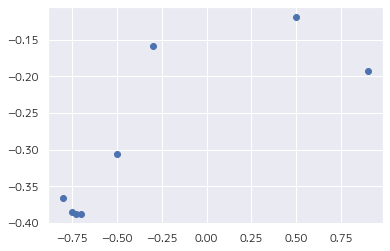

In [10]:
plt.scatter(x_train, y_train)

In [11]:
def kernel(x, x_dash, theta1=1, theta2=0.4, theta3=0.001):
    return theta1 * np.exp(-((x - x_dash) ** 2) / theta2) + (
        theta3 if x == x_dash else 0
    )

In [12]:
def calc_K(x_train) -> np.ndarray:
    N = len(x_train)
    K = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            K[i, j] = kernel(x_train[i], x_train[j])
    return K


def predict(K, x_train, x_test):
    N = len(x_train)
    M = len(x_test)
    mu = np.zeros(M)
    var = np.zeros(M)

    y_train = func(x_train)
    yy = np.linalg.inv(K) @ y_train
    for i in range(M):
        k = np.zeros(N)
        for j in range(N):
            k[j] = kernel(x_train[j], x_test[i])
        s = kernel(x_test[i], x_test[i])
        mu[i] = k @ yy
        var[i] = s - k @ np.linalg.inv(K) @ k
    return mu, var

In [13]:
K = calc_K(x_train)
mu, var = predict(K, x_train, x_test)

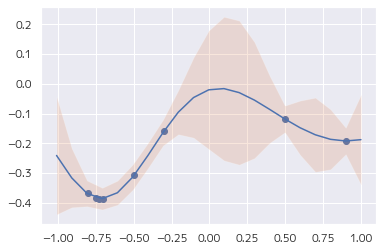

In [14]:
def plot(x_train, y_train, x_test, mu):
    plt.plot(x_test, mu)
    plt.scatter(x_train, y_train)
    std = [np.sqrt(v) if v > 1e-10 else 1e-5 for v in var]
    plt.fill_between(x_test, mu - std, mu + std, alpha=0.2)


plot(x_train, y_train, x_test, mu)

## ei

In [15]:
def gpei(x_test, max_iter=6):
    x_trial = np.random.rand(1) * 2 - 1
    y_trial = func(x_trial)
    for i in range(max_iter):
        tau = np.max(y_trial)
        K = calc_K(x_trial)
        mu, var = predict(K, x_trial, x_test)
        std = [np.sqrt(v) if v > 1e-10 else 1e-5 for v in var]
        t = (x_test - mu) / std
        
        alpha = (mu - tau) * norm.cdf(t) + std * norm.pdf(t)
        x_trial = np.append(x_trial, x_test[np.argmax(alpha)])
        y_trial = func(x_trial)
    return x_trial, y_trial

In [16]:
x_test = np.linspace(-1.01, 1, 21)
x_trial, y_trial = gpei(x_test)

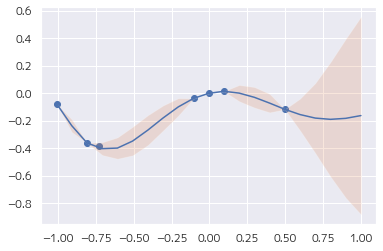

In [17]:
K = calc_K(x_trial)
mu, var = predict(K, x_trial, x_test)
plot(x_trial, y_trial, x_test, mu)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


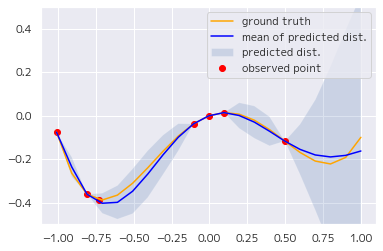

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

def update(frame):
    ax.cla()
    K = calc_K(x_trial[:frame+1])
    mu, var = predict(K, x_trial[:frame+1], x_test)
    std = [np.sqrt(v) if v > 1e-10 else 1e-5 for v in var]
    
    ax.plot(x_test, func(x_test),color="orange",label="ground truth")
    ax.plot(x_test, mu,color="blue",label="mean of predicted dist.")
    ax.fill_between(x_test, mu - std, mu + std, alpha=0.2,label="predicted dist.")
    ax.scatter(x_trial[:frame+1], y_trial[:frame+1],color="red",label="observed point")
    ax.set_ylim([-0.5,0.5])
    ax.legend()

anim = FuncAnimation(fig, update, frames=range(8), interval=1000)
anim.save("gpei.gif", writer="imagemagick")